In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy import sparse
from scipy import optimize
from scipy import signal
from scipy import linalg
from functools import reduce
from collections import defaultdict
import pprint
from tqdm.notebook import tqdm
import pandas as pd # Only here to print arrays nicely

In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

# TOC
1. [1x1 Beam Functions](#1x1)
2. [NxN Beam Complications](#NxN)
3. [Visibility Solving](#vis)
4. [Beam Solving](#beams)
5. [Plots](#plots)
6. [Data Tables](#datatables)
7. [Playground](#playground)

### Simplified case for 1x1 beam <a name="1x1"></a>

In [3]:
def get_num_baselines(Nside):
    # For square of N telescopes, should be 2N-2*sqrt(N) + 1
    # Fix to a corner and there are N-1 options for unique baselines. 
    # Flip over to other side (over x or y axis) and get another N-1 options
    # Duplicated Qare the pure x-axis and pure y-axis so -2*(sqrt(N)-1)
    # Final +1 is from 0 baseline
    
    N_bases = 2*Nside**2 - 2*Nside
    return int(N_bases)

rand_phases = lambda x: np.random.uniform(0, 2*np.pi, x)
zero_weight = lambda x, d: x/d if d else 0
vector_weight = lambda x, d: np.divide(x, d, out=np.zeros_like(x, dtype=np.float), where=(d!=0))
parray = lambda x: np.round(x, decimals=2)

def make_gains(Nside):
    # Create complex gains with either (amplitude, phase) or (real, imaginary)
    Nant = Nside**2
    gain_amp = np.random.normal(1, .05, Nant)
    gain_phase = rand_phases(Nant)
    tgain = gain_amp*np.exp(1j*gain_phase)    
    return tgain

def make_data(Nside, gains, noise=0.1):
    Nant = Nside**2
    Nbase = get_num_baselines(Nside)
    vis_true = np.random.normal(0,1,size=(Nbase,2)).view(np.complex128).flatten() ## size of unique baselines
    ant_i, ant_j, visndx, data = [], [], [], []
    ndx=0
    ndx2base={}
    base2ndx={}
    for i in range(Nant):
        xi,yi=np.unravel_index(i,(Nside,Nside))
        for j in range (i+1,Nant):
            xj,yj=np.unravel_index(j,(Nside,Nside))
            assert (xj>=xi)
            baseline = (xj-xi,yj-yi)
            if baseline in base2ndx:
                cndx = base2ndx[baseline]
            else:
                cndx = ndx
                base2ndx[baseline]=ndx
                ndx2base[ndx]=baseline
                ndx+=1
            ant_i.append(i)
            ant_j.append(j)
            visndx.append(cndx)
            data.append(vis_true[cndx]*gains[i]*np.conj(gains[j]))
            
    assert(ndx==Nbase)
    ant_i = np.array(ant_i)
    ant_j = np.array(ant_j)
    visndx = np.array(visndx)
    data = np.array(data)
    noise = np.random.normal(0,noise,size=(len(data),2)).view(np.complex128).flatten() ## size of unique baselines
    data += noise
    return vis_true, data, ant_i, ant_j, visndx, ndx2base, base2ndx

In [4]:
def make_pred(gains, vis, ant_i, ant_j, visndx):
    gains_i = gains[ant_i]
    cgains_j = np.conj(gains[ant_j])
    pred = gains_i*cgains_j*vis[visndx]
    return pred

In [5]:
def chi2(data, gains, vis, ant_i, ant_j, visndx, noise=0.1):
    pred = make_pred(gains, vis, ant_i, ant_j, visndx)
    chi2 = np.abs((data - pred)**2).sum()/(noise**2)
    dof = len(data)*2
    return chi2, dof

In [6]:
def chimincal(iter_max, data, g0, v0, ant_i, ant_j, visndx, noise=0.1, delta=0.4, epsilon=1e-5):
    chiscores = []
    garr = g0.copy()
    varr = v0.copy()
    N = 1
    Nant = len(g0)
    Nbase = len(v0)
    
    chi, dof = chi2(data, garr, varr, ant_i, ant_j, visndx)
    chiscores.append(chi/dof)
    
    
    for n in tqdm(range(iter_max)):
        gprime = np.zeros(Nant, dtype=np.complex128)
        for i in range(Nant):
            numer = np.complex(0, 0)
            denom = np.complex(0, 0)
            iant = np.where(ant_i == i)[0]
            jant = np.where(ant_j == i)[0]
            numer += (data[iant] * garr[ant_j[iant]]*np.conj(varr[visndx[iant]])).sum()
            denom += (np.abs(garr[ant_j[iant]]*varr[visndx[iant]])**2).sum()
            numer += (np.conj(data[jant]) * garr[ant_i[jant]]*varr[visndx[jant]]).sum()
            denom += (np.abs(garr[ant_i[jant]]*varr[visndx[jant]])**2).sum()
            gprime[i] += zero_weight(numer, denom)

        garr = (1 - delta)*garr + delta*gprime
        
        vprime = np.zeros(Nbase, dtype=np.complex128)
        for i in range(Nbase):
#             vdata = data/(garr[ant_i]*np.conj(garr[ant_j]))
#             vprime[i] = np.mean(vdata[visndx==i])
            
#             numer = data[indxs].sum()
#             denom = (garr[ant_i[indxs]]*np.conj(garr[ant_j[indxs]])).sum()
#             vprime[i] += zero_weight(numer, denom)

            indxs = np.where(visndx==i)
            numer = (data[indxs]*np.conj(garr[ant_i[indxs]])*garr[ant_j[indxs]]).sum()
            denom = (np.abs(garr[ant_i[indxs]]*np.conj(garr[ant_j[indxs]]))**2).sum()
            vprime[i] = zero_weight(numer, denom)

        varr = (1-delta)*varr + delta*vprime
#         varr = vprime

        gscale = N/np.mean(np.abs(garr))
        garr *= gscale
        varr *= (1/gscale)**2
        
        chi, dof = chi2(data, garr, varr, ant_i, ant_j, visndx)
        chiscores.append(chi/dof)
        if n > 20:
            if np.abs(chiscores[-2] - chiscores[-1]) < epsilon:
                break
    return garr, varr, chiscores, n

### NxN beam complications <a name="NxN"></a>

In [7]:
def get_weighted_array(alpha, Nspacing, numdraws=1e5):
    # Overlap a circular beam onto a pixelized grid 
    Nbeam = Nspacing**2
    rmax = alpha*.5
    ndraws = int(numdraws)
    spacing = np.linspace(0,1,Nspacing+1)
    centered_spacing = spacing - .5
    empty_weight_beam = np.zeros((Nspacing, Nspacing), dtype=np.complex128)
    
    for i in range(Nbeam):
        xi, yi = np.unravel_index(i, (Nspacing, Nspacing))
        draws = np.array([np.random.uniform(centered_spacing[xi], centered_spacing[xi+1], ndraws), np.random.uniform(centered_spacing[yi], centered_spacing[yi+1], ndraws)])
        dist = np.linalg.norm(draws, axis=0)
        empty_weight_beam[xi, yi] = np.sum(dist < rmax)/ndraws #* np.exp(1j*rand_phases(1))
#     sym_beam = .5*(empty_weight_beam + empty_weight_beam.T)
    return empty_weight_beam

In [8]:
# Helper function to get a (2*br-1, 2*br-1) grid around point x

def n_mesh(br):
    nmesh = lambda x: tuple(np.meshgrid(range(x[0]-br, x[0]+br+1), range(x[1]-br, x[1]+br+1), indexing='ij'))
    return nmesh

five_mesh = n_mesh(2)

In [9]:
def make_uv_grid(Nside):
    uv_size = Nside*2 - 1
    center = (Nside-1,Nside-1)
    npcenter = np.array(center)
    img_size = (uv_size, uv_size)
    random_image = np.random.normal(0, 1, img_size)
    centered_uv = np.fft.fftshift(np.fft.fft2(random_image))
#     centered_uv[center] = 0
    topleft_uv = np.fft.ifftshift(centered_uv)
    
    return centered_uv, topleft_uv, npcenter

In [10]:
def get_new_shape(Nside, beam_radius=3):
    # Helper function to get shape of convolved u-v space
    orig_shape = (2*Nside-1, Nside)
    new_shape = tuple([i*beam_radius + (beam_radius - 1) for i in orig_shape])
    return new_shape

In [11]:
def make_visibilities(Nside, beam_radius):
    n = Nside
    br = beam_radius
    
    # Useful shapes/sizes to have on hand
    new_shape = get_new_shape(n, br)
    new_size = np.prod(new_shape)
    center = (int((new_shape[0]-1)/2), br-1)
    
    #Matrices of visibiltiies and possible indices
    random_vis = np.random.normal(0,1 , (new_shape[0], new_shape[1], 2)).view(np.complex128)
    poss_index = np.arange(new_size).reshape(new_shape)
    
    #Clear off the leftmost columns to remove redundant conjugate stuff
    poss_index[0:center[0], 0:br] = 0
    poss_index[center[0]:, 0:br-1] = 0
    
    oversampled_baselines = poss_index.nonzero()[0].shape[0]
    visib = np.zeros(oversampled_baselines, dtype=np.complex128)
    #Baseline - index dictionaries
    new_ndx = 0
    n2b = {}
    b2n = {}
    n2true = {}
    true2n = {}
    for i in range(new_size):
        xi,yi = np.unravel_index(i, new_shape)
        if poss_index[xi,yi] == 0:
            continue
        else:
            baseline = (xi-center[0], yi-center[1])
            if baseline[0] < 0:
                baseline = (-1*baseline[0], -1*baseline[1])

            if baseline in b2n:
                cndx = new_ndx
            else:
                cndx = new_ndx
                b2n[baseline] = new_ndx
                n2b[new_ndx] = baseline
                if tuple(np.mod(baseline, br)) == (0,0):
                    modtuple = tuple(np.floor_divide(baseline, br))
                    true2n[modtuple] = new_ndx
                    n2true[new_ndx] = modtuple
                new_ndx += 1
        visib[cndx] = random_vis[xi,yi]
    return n2b, b2n, n2true, true2n, visib

In [12]:
def vis_to_grid(visib, ndx2base, size):
    # Turn our flat list of visibilities into a grid based on the dictionary
    # Meshes make properly yanking data from a grid straight-forward and also takes into account proper
    # negative indexing which makes it preferable to the flat visibility list.
    
    # Double the size to make sure to avoid rewriting values with negative indexing
    uv_size = (2*size[0], 2*size[1])
    new_grid = np.zeros(uv_size, dtype=np.complex128)
    for i,v in enumerate(visib):
        base = ndx2base[i]
        inv_base = tuple(-1*np.array(base))
        new_grid[base] = v
        new_grid[inv_base] = np.conj(v)
    return new_grid

In [13]:
def create_fake_flatndx(Nside, n_beam):
    Nant = Nside**2
    conv_beamrad = 2*n_beam - 1
    n2b, b2n, n2t, t2n, _ = make_visibilities(Nside, n_beam)
    datandx = []
    ant_i = []
    ant_j = []
    
    mesh = n_mesh(n_beam - 1)
    
    for i in range(Nant):
        xi,yi = np.unravel_index(i, (Nside, Nside))
        for j in range(i+1, Nant):
            ant_i.append(i)
            ant_j.append(j)
            xj,yj = np.unravel_index(j, (Nside, Nside))
            assert (xj>=xi)
            baseline = (xj-xi,yj-yi)
            
            virtual_n = t2n[baseline]
            grid_base = n2b[virtual_n]
            
            virtual_points = mesh(grid_base)
            
            datandx.append(virtual_points)
    flat = vector_b2n(b2n, datandx)
    ant_i = np.array(ant_i)
    ant_j = np.array(ant_j)
    return flat, ant_i, ant_j

In [14]:
def make_data_grid(Nside, gains, beams, visfactor=1, noise=0.1, verbose=True):
    
    Nant = Nside**2
    Nbase = get_num_baselines(Nside)
    # Get sample beam to understand shape of convolved beams
    samp_beam = signal.convolve(beams[0], beams[0])
    
    #Radius and corresponding mesh
    beam_radius = int((samp_beam.shape[0]-1)/2) + 1
    mesh = n_mesh(beam_radius-1)
    
    # Create visibilities
    n2b, b2n, n2t, t2n, visib = make_visibilities(Nside, beam_radius)
    if verbose:
        print("Made visib")
    visib *= visfactor
    
    new_shape = get_new_shape(Nside, beam_radius)
    vis_grid = vis_to_grid(visib, n2b, new_shape)
    if verbose:
        print("Made grid")
    
    ant_i, ant_j, visndx, data, datandx = [], [], [], [], []
    
    for i in range(Nant):
        xi,yi=np.unravel_index(i,(Nside, Nside))
        for j in range (i+1,Nant):
            conv_beam = signal.convolve(beams[i], np.conj(beams[j][::-1, ::-1]))
            xj,yj=np.unravel_index(j,(Nside, Nside))
            assert (xj>=xi)
            baseline = (xj-xi,yj-yi)
            
            virtual_n = t2n[baseline]
            grid_base = n2b[virtual_n]
            
            virtual_points = mesh(grid_base)
            data_sum = (vis_grid[virtual_points] * gains[i] * np.conj(gains[j]) * conv_beam).sum()
            
            ant_i.append(i)
            ant_j.append(j)
            visndx.append(virtual_n)
            data.append(data_sum)
            datandx.append(virtual_points)
    
    if verbose:
        print("Created data")
    
    ant_i = np.array(ant_i)
    ant_j = np.array(ant_j)
    visndx = np.array(visndx)
    data = np.array(data)
    noise = np.random.normal(0,noise,size=(len(data),2)).view(np.complex128).flatten() ## size of unique baselines
    data += noise
    return visib, data, ant_i, ant_j, visndx, datandx, n2b, b2n, n2t, t2n, vis_grid

In [15]:
def vector_b2n(b2n, datandx):
    # Convert datandx (points on the grid) to flat indices using b2n dictionary
    newndx = []
    for l in datandx:
        x,y = l
        flattened = []
        ndx_size = x.size
        ndx_shape = x.shape
        for i in range(ndx_size):
            point = np.unravel_index(i, ndx_shape)
            k = np.array([x[point], y[point]])
            key = tuple(k)
            if key in b2n:
                flattened.append(b2n[key])
            else:
                key = tuple(-1*k)
                flattened.append(-1*b2n[key])
        newndx.append(flattened)
    newndx = np.array(newndx)
    return newndx

In [16]:
def conjugate_visib(vis, ndxs):
    # Returns the proper list of relevant visibilites given ndxs
    # Negative refers to using a conjugate rather than doubling the size of the array
    flat = []
    for i in ndxs:
        if i >= 0:
            flat.append(vis[i])
        else:
            flat.append(np.conj(vis[-1*i]))
    return np.array(flat)

In [17]:
def flat_model(vis, beams, gains, ant_i, ant_j, flatndx):
    # Make prediction
    postage = np.array([signal.convolve(beams[ant_i[i]], np.conjugate(beams[ant_j[i]][::-1, ::-1])).flatten() for i in range(len(flatndx))])
    gains_i = gains[ant_i]
    gains_j = np.conj(gains[ant_j])
    flatbread = np.array([conjugate_visib(vis, v)*postage[i] for i, v in enumerate(flatndx)])
    pred = np.sum(flatbread, axis=1)*gains_i*gains_j
    return pred

In [18]:
def gen_chi2(data, pred, noise=0.1):
    # Generic chi2 definition
    chitwo = np.abs((data - pred)**2).sum()/(noise**2)
    dof = len(data)*2
    return chitwo, dof, chitwo/dof

### Visibility solving <a name="vis"></a>

In [19]:
def imag_to_reals(vec):
    # Helper function for linear estimator
    reals = vec.real
    imags = vec.imag
    flat_vec = np.concatenate((reals, imags))
    return flat_vec

In [1546]:
def reals_to_imag(vec):
    vlen = int(len(vec)/2)
    comp_vec = vec[:vlen] + 1j*vec[vlen:]
    return comp_vec

In [1339]:
def linear_solver_A(beams, gains, data, ant_i, ant_j, fndx):
    # Solve for visibilities using a linear method
    big_ans = imag_to_reals(data)
    data_len = len(data)
    v_size = len(set(np.abs(fndx).flatten())) + 1
    postage = np.array([signal.convolve(beams[ant_i[i]], np.conjugate(beams[ant_j[i]][::-1, ::-1])).flatten()*gains[ant_i[i]]*np.conjugate(gains[ant_j[i]]) for i in range(len(fndx))])
    bigA = sparse.lil_matrix((2*data_len, 2*v_size))
    for i,v in enumerate(fndx):
        absv = np.abs(v)
        bigA[i,absv] = postage[i].real
        bigA[i, v_size+absv] = -1*np.sign(v)*postage[i].imag
        bigA[i+data_len, absv] = postage[i].imag
        bigA[i+data_len, v_size+absv] = np.sign(v)*postage[i].real
    bigCSR = bigA.tocsr()
    return bigCSR, big_ans

In [1617]:
def vis_solv(vis, beams, gains, data, noise, ant_i, ant_j, fndx, fvis):
    bigA, bigB = linear_solver_A(beams, gains_true, data, ant_i, ant_j, fndx)
    At = bigA.T
    sinv = sparse.diags(np.ones(2*fvis))
    ninv = sparse.diags(noise*np.ones(2*len(data)))
    lhs = (sinv + At@ninv@bigA)
    rhs = (At@ninv)@bigB
    wein_m  = reals_to_imag(sparse.linalg.spsolve(lhs, rhs))
    return wein_m

In [1616]:
def old_vis_solver(guess, beams, gains, data, ant_i, ant_j, fndx):
    bigA, bigB = linear_solver_A(beams, gains, data, ant_i, ant_j, fndx)
    map_sol = sparse.linalg.lsqr(bigA, bigB, atol=1e-9)[0]
    comb_sol = reals_to_imag(map_sol)
    return comb_sol

### Beam solving <a name="beams"></a>

In [22]:
def padded_circulant(col):
    c_len = len(col)
    first_row = np.zeros(c_len, dtype=np.complex128)
    first_row[0] = col[0]
    first_col = np.zeros(2*c_len - 1, dtype=np.complex128)
    first_col[0:c_len] = col
    toep_mat = linalg.toeplitz(first_col, first_row)
    return toep_mat

In [23]:
def doubly_block_toep(beam_j):
    pad_zero = np.zeros(beam_j.shape[0], dtype=np.complex128)
    h1 = padded_circulant(beam_j[0])
    h2 = padded_circulant(beam_j[1])
    h3 = padded_circulant(beam_j[2])
    h4 = padded_circulant(pad_zero)
    h5 = padded_circulant(pad_zero)
    blocked_toep = np.block([
        [h1, h5, h4],
        [h2, h1, h5],
        [h3, h2, h1],
        [h4, h3, h2],
        [h5, h4, h3]
    ])
    return blocked_toep

In [24]:
def generic_block_toep(beam_j):
    pad_zero = np.zeros(beam_j.shape[0], dtype=np.complex128)
    nb = beam_j.shape[0]
    finshape = 2*nb - 1
    block_matrix = []
    circ_ndx = linalg.circulant(np.arange(finshape))[:,0:nb]
    for i in range(finshape):
        if i < nb:
            block_matrix.append(padded_circulant(beam_j[i]))
        else:
            block_matrix.append(padded_circulant(pad_zero))
    blocked = np.array(block_matrix)
    unshape_circ = blocked[circ_ndx]
    shaped_circ = unshape_circ.transpose(0, 2, 1, 3).reshape(finshape**2, nb**2)
    return shaped_circ   

In [25]:
def beam_mean(beams):
    avg_beam = np.sum(np.mean(beams, axis=0))
    meaned_beams = beams/avg_beam
    return meaned_beams

In [1121]:
def beam_solver(vis, beam_guess, gains, data, ant_i, ant_j, flatndx, Nside):
    Nant = Nside**2
    n_beam = beam_guess.shape[1]
    fn_bm = 2*n_beam - 1
    matrix_beams = np.zeros((beam_guess.shape[0], fn_bm**2, n_beam**2), dtype=np.complex128)
    
    symbeam = int((n_beam + 1)/2)
    symconv = signal.convolve(np.ones((symbeam, symbeam), dtype=np.complex128), np.ones((symbeam, symbeam), dtype=np.complex128)).flatten()
    center_ofsymbeam = int((n_beam**2 - 1)/2)

    for i,v in enumerate(beam_guess):
        matrix_beams[i] = generic_block_toep(v)
    
    matrix_beams = np.array(matrix_beams)
    
    new_beams = beam_guess.copy()
    for ant_ndx in range(Nant):
        beam_solver = np.zeros((Nant-1, n_beam**2), dtype=np.complex128)
        rhs_vis = np.zeros(Nant-1, dtype=np.complex128)
        
        ant_filter = ant_i==ant_ndx
        sum_ants = np.sum(ant_filter)
        jant_filter = ant_j==ant_ndx
        
        rhs_vis[:sum_ants] = data[ant_filter]
        rhs_vis[sum_ants:] = np.conjugate(data[jant_filter])                    
        
        for i in range(sum_ants):
            beam_solver[i] = conjugate_visib(vis, flatndx[ant_filter][i])[None,:] \
                @ np.conjugate(matrix_beams[ant_j[ant_filter]][i][::-1, ::-1])*gains[ant_i[ant_filter]][i]*np.conjugate(gains[ant_j[ant_filter]][i])
        for j in range(np.sum(jant_filter)):
            beam_solver[sum_ants + j] = (np.conjugate(conjugate_visib(vis, flatndx[jant_filter][j])[None,:]) \
                @ np.conjugate(matrix_beams[ant_i[jant_filter]][j]))[::-1,::-1]*gains[ant_j[jant_filter]][j]*np.conjugate(gains[ant_i[jant_filter]][j])
        
#         if enforce_sym:
#             for j in set(symconv):
#                 jsymline = np.zeros(n_beam**2, dtype=np.complex128)
#                 if j==symconv[center_ofsymbeam]:
# #                     jsymline = np.zeros(n_beam**2, dtype=np.complex128)
# #                     jsymline[center_ofsymbeam] = 1*50
# #                     beam_solver = np.concatenate((beam_solver, jsymline[None,:]))
# #                     rhs_vis = np.concatenate((rhs_vis, [50*bcenter[ant_ndx]]))
#                     continue
#                 else:
#                     jsymndx = np.where(symconv == j)[0]
#                     symlen = len(jsymndx)
#                     for k in range(symlen):
#                         for l in range(k+1, symlen):
#                             ksymline = np.zeros(n_beam**2, dtype=np.complex128)
#                             ksymline[jsymndx[k]] = 50
#                             ksymline[jsymndx[l]] = -50
#                             beam_solver = np.concatenate((beam_solver, ksymline[None,:]))
#                             rhs_vis = np.concatenate((rhs_vis, [0]))

            
#         zerobeam = np.linalg.lstsq(beam_solver, rhs_vis, rcond=None)[0]
        
        zerobeam = optimize.lsq_linear(beam_solver, rhs_vis).x
        shaped_beam = zerobeam.reshape((n_beam, n_beam))
        matrix_beams[ant_ndx] = generic_block_toep(shaped_beam)
        new_beams[ant_ndx] = shaped_beam
    return new_beams

In [1657]:
def solve_everything(iter_max, vis_guess, beam_guess, gains, data, ant_i, ant_j, flatndx, Nside, noise, chi_eps=1):
    chis = []
    scores = []
    model = flat_model(vis_guess, beam_guess, gains, ant_i, ant_j, flatndx)
    chi, _, score = gen_chi2(data, model, noise)
    chis.append(chi)
    scores.append(score)
    fvis = len(vis_guess)
    for n in tqdm(range(iter_max)):

        new_vis = vis_solv(vis_guess, beam_guess, gains, data, noise, ant_i, ant_j, flatndx, fvis)
            
        vis_guess = new_vis
        
        new_beams = beam_solver(vis_guess, beam_guess, gains, data, ant_i, ant_j, flatndx, Nside)
        beam_guess = new_beams
        
        model = flat_model(vis_guess, beam_guess, gains, ant_i, ant_j, flatndx)
        chi, _, score = gen_chi2(data, model, noise)
        
        chis.append(chi)
        scores.append(score)
        if n > 5:
            if (np.abs(chi - chis[-2]) < chi_eps):
                break
            if score < 1:
                break
        if n%5==0:
            print(n, score)
        
    chis = np.array(chis)
    scores = np.array(scores)
    print(n, score)
    
    return vis_guess, beam_guess, chis, scores

In [28]:
def scale_phased(vis, beams, beam_scale, phase, n2b, n_beam):
    term_phase = np.array([np.array(n2b[n])/n_beam for n in np.arange(len(n2b))])
    beam_ndx = np.array(np.unravel_index(np.arange(len(beams)), (Nside, Nside)))
    phase_dphi = phase
    
    phase_vis = vis*np.exp(1j*np.dot(term_phase, phase_dphi))

    beam_r = int((n_beam-1)/2)
    beam_mesh = n_mesh(beam_r)
    
    phase_beams = []
    for i in range(len(beam_ndx[0])):
        pos_beamy, pos_beamx = np.array(beam_mesh(beam_ndx[:,i]*n_beam))/n_beam
        beam_flipped = np.array([pos_beamy[::-1], pos_beamx[:,::-1]])
        offsets = np.sum(beam_flipped*phase_dphi[:,None,None], axis=0)
        phase_vec = np.exp(1j*offsets)
        phase_beams.append(beams[i]*phase_vec)
    phase_beams = np.array(phase_beams)
    
    fin_beams = phase_beams * beam_scale
    fin_vis = phase_vis * (1/beam_scale)**2
    return fin_vis, fin_beams

#### Generate data and set up variables

In [1658]:
Nside = 10
Nant = Nside * Nside
Nbase = get_num_baselines(Nside)
noise = .1
gains_true = np.ones(Nant)
n_beam = 5
# beam_gains = np.random.normal(1,.1,(Nant, 2)).view(dtype=np.complex128).flatten()
beam_comp_phase = np.exp(1j*rand_phases(Nant))
unmean_beams = np.array([get_weighted_array(.83, n_beam, 100)*beam_comp_phase[i] for i in range(Nant)])
beams = unmean_beams

In [1659]:
# for i,b in enumerate(beams):
#     beams[i] = np.roll(b, np.random.randint(0,2), axis=np.random.randint(0,2))
#     beams[i] = np.roll(b, 1, axis=0)

# _, beams = scale_phased(vis_true, beams, 1, np.array([.1, .5]), n2b, n_beam)

In [1660]:
# beams = beams + 1e-5*np.random.random((*beams.shape, 2)).view(dtype=np.complex128).reshape(beams.shape)

In [1661]:
vis_true, data, ant_i, ant_j, visndx, datandx, n2b, b2n, n2t, t2n, tl_grid = make_data_grid(Nside, gains_true, beams, visfactor=1, noise=noise)
# flatndx = vector_b2n(b2n, datandx)
data_len = len(data)

Made visib
Made grid
Created data


In [1662]:
conv_beam_size = (2*n_beam - 1)**2
beam_size = n_beam**2

#### Check that the correct values give us a good prediction

In [1663]:
# flatbread = flat_model(vis_true, beams, gains_true, ant_i, ant_j, flatndx)
# print("Flat solution ", gen_chi2(data, flatbread, noise))

#### Solve for the relevant properties given "bad" guesses

In [1664]:
outbeam = 3

In [1665]:
bshape = (len(beams), outbeam, outbeam)

In [1666]:
fakeflat, fanti, fantj = create_fake_flatndx(Nside, outbeam)

In [1667]:
fakevislen = len(set(np.abs(fakeflat).flatten()))+1

In [1668]:
bad_guess = np.random.normal(0, 1, (fakevislen, 2)).view(np.complex128).flatten()
improv_beam = np.random.normal(0, 1, (*bshape, 2)).view(np.complex128).reshape(bshape)

In [1669]:
horrific = flat_model(bad_guess, improv_beam, gains_true, ant_i, ant_j, fakeflat)
print("Guess solution ", gen_chi2(data, horrific, noise))

Guess solution  (1403703643.0429735, 9900, 141788.24677201753)


In [1671]:
itersolve = solve_everything(500, bad_guess, improv_beam, gains_true, data, ant_i, ant_j, fakeflat, Nside, noise)

0 55851.86114389125



KeyboardInterrupt: 

In [1654]:
challah = flat_model(itersolve[0], itersolve[1], gains_true, ant_i, ant_j, fakeflat)
print("Flat solution ", gen_chi2(data, challah, noise))

Flat solution  (62256.170720426606, 9900, 6.288502092972385)


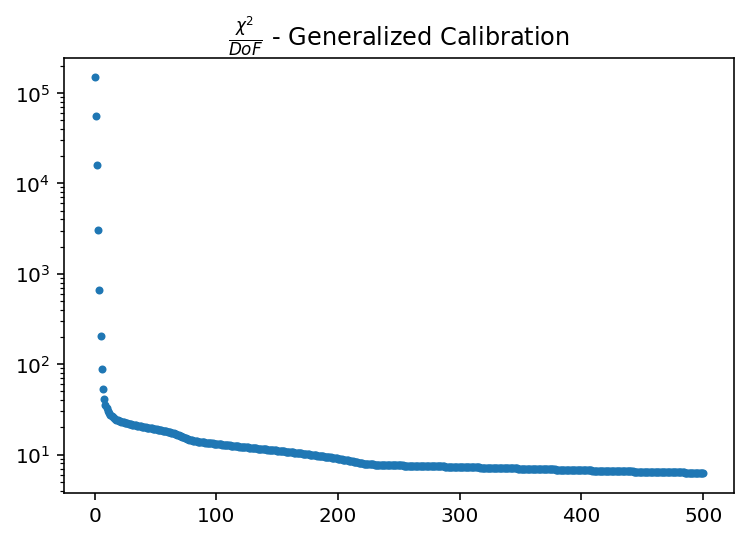

In [1655]:
# plt.plot(np.log10(itersolve[-1]), '.');
# plt.title(r"$\log{\left(\frac {\chi^2}{DoF}\right)}$");

plt.plot(itersolve[-1], '.');
plt.title(r"$\frac{\chi^2}{DoF}$ - Generalized Calibration");

plt.semilogy();

#### Check phase degeneracy

In [89]:
phase_vis, phase_beams = scale_phased(vis_true, beams, 1, np.array([.12, .1]), n2b, n_beam)

In [90]:
pita = flat_model(phase_vis, phase_beams, gains_true, ant_i, ant_j, flatndx)
print("Flat solution ", gen_chi2(data, pita, noise))

Flat solution  (20526.517035332265, 20592, 0.9968199803483034)


#### Show that standard redundant calibration is bad

In [913]:
bad_guess = np.random.normal(0, 1, (len(vis_true), 2)).view(np.complex128).flatten()
beam_gain_guess = np.random.normal(0, 1, (Nant, 2)).view(np.complex128).flatten()

In [914]:
chig, chiv, c, n = chimincal(100, data, beam_gain_guess, bad_guess, ant_i, ant_j, visndx, delta=.4)

5.678525530034449


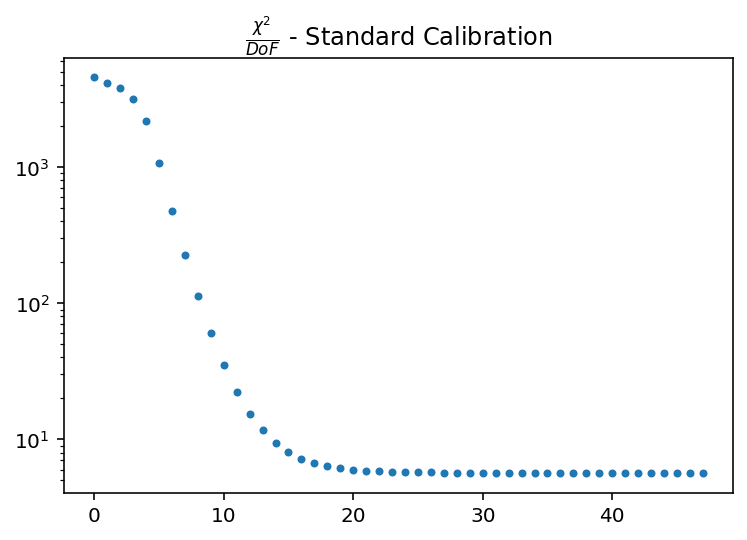

In [915]:
plt.plot(c, '.');
plt.title(r"$\frac{\chi^2}{DoF}$ - Standard Calibration")
plt.semilogy()
print(c[-1])

### Paper Plots <a name="plots"></a>

In [472]:
ns = np.arange(2,201)
na = ns**2
ms = np.array([0,1,2,5,10,15,30])

In [479]:
num = ns*(na-1)
denom = lambda m : 2*((2*m+1)*(6*m*ns + 3*ns - 2))

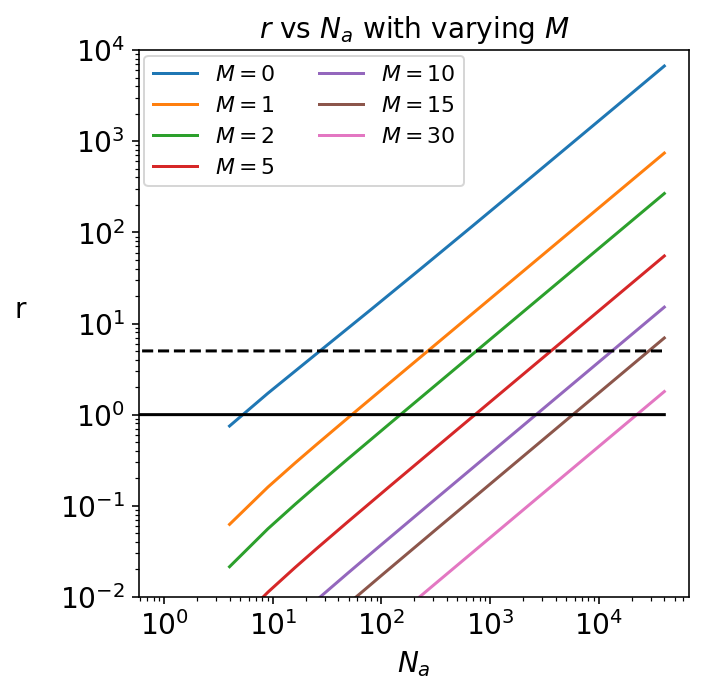

In [480]:
plt.figure(figsize=(5,5))
for m in ms:
    plt.plot(na, vector_weight(num, denom(m)), label=r'$M = $'+(str(m)))
plt.legend(loc='upper center', bbox_to_anchor=(0.3, 1.01), ncol=2, fontsize=11)

plt.plot(np.ones(na[-1]), color='black')
plt.plot(np.ones(na[-1])+4, '--', color='black')
plt.xlabel(r"$N_a$", fontsize=14);
plt.ylabel("r", rotation=0, labelpad=20, fontsize=14);
plt.title(r"$r$ vs $N_a$ with varying $M$", fontsize=14)
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-2, 1e4)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()

### Data Tables <a name="datatables"></a>

| Nside | M | M' | sec/iter | DoF | After 20 |
| :---:|  :---:| :---:| :---:| :---:| :---:|
| 10 | 5 | 3 | 7.2 | 9900 | NA |
| 15 | 5 | 3 | 33.3 | 50400 | 50.05 |
| 20 | 5 | 3 |  | 159600 | |

Using M=11 for now. Geometry is in terms pixels with (x,y) convention. Pointing is in radian (x, y).

| Nside | M | M' | Geometry | Pointing | After 10 | Starting |
| :---:|  :---:| :---:| :---:| :---:| :---:| :---:| 
| 12 | 11 | 3 | 0 | 0 | 419678.48 | |
| 12 | 11 | 3 | (0,1) | 0 | 225139.55 | |
| 12 | 11 | 3 | 0 | (.1, .5) | 118670.47 | |
| 12 | 5 | 3 | 0 | 0 | 804.03 | 147973.03|
| 12 | 5 | 3 | (0,1) | 0 | 5826.25 | 136280.30 | 
| 12 | 5 | 3 | 0 | (.1, .5) |  6747.39 | 149739.27 |

### Below this is my random testing/playground <a name="playground"></a>

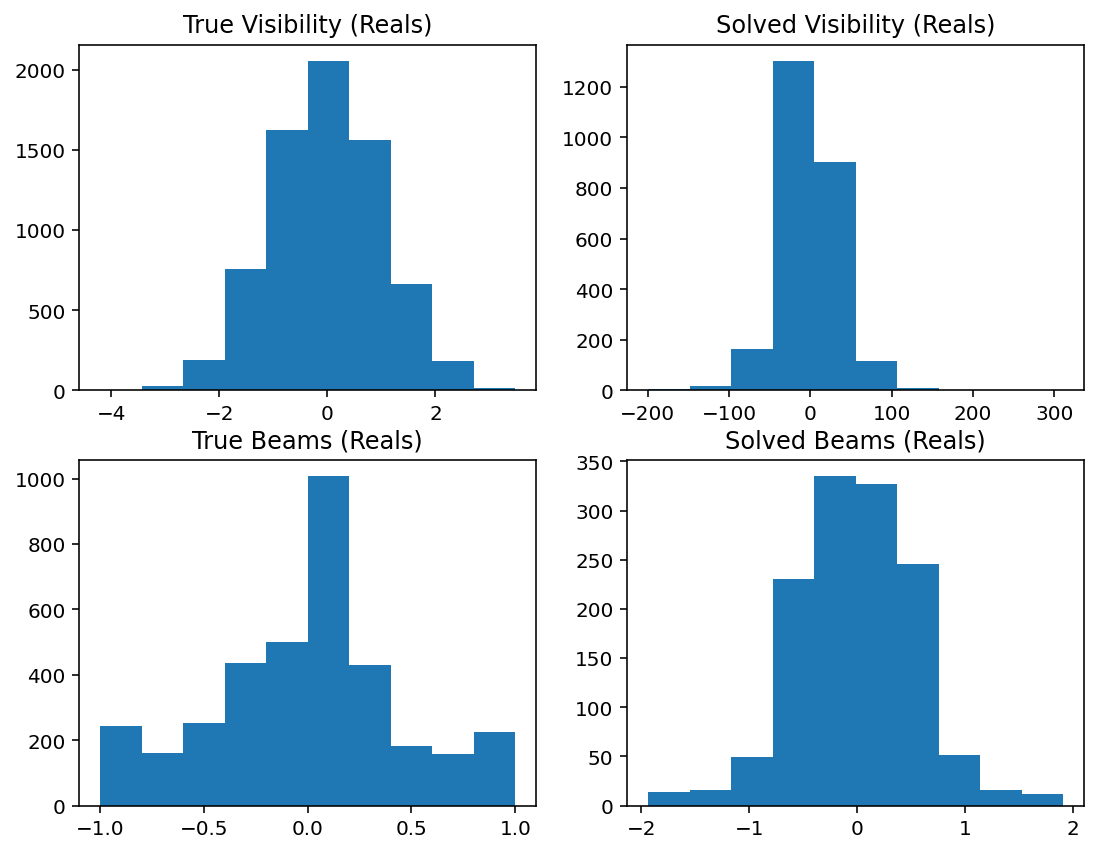

In [712]:
fig, ax = plt.subplots(2, 2, figsize=(9,7))

ax[0,0].hist(vis_true.real);
ax[0,0].set_title("True Visibility (Reals)");

ax[0,1].hist(itersolve[0].real);
ax[0,1].set_title("Solved Visibility (Reals)");

ax[1,0].hist(beams.flatten().real);
ax[1,0].set_title("True Beams (Reals)");

ax[1,1].hist(itersolve[1].flatten().real);
ax[1,1].set_title("Solved Beams (Reals)");

In [426]:
# print("True vis variance: ", np.var(vis_true.real))
# print("Solved vis variance using n_beam="+str(outbeam), np.var(itersolve[0].real))

# print("True beam variance: ", np.var(beams.real))
# print("Solved beam variance using n_beam="+str(outbeam), np.var(itersolve[1].real))

# print("True vis variance: ", np.var(vis_true.real))
# print("Solved vis variance using n_beam="+str(outbeam), np.var(itersolve[0].real))

# print("True beam variance: ", np.var(beams.real))
# print("Solved beam variance using n_beam="+str(outbeam), np.var(itersolve[1].real))

In [819]:
solved_beam_avgs = np.array([np.sum(b) for b in itersolve[1]])
# solved_beam_avgs = np.array([np.sum(b) for b in improv_beam])
orig_beam_avgs = np.array([np.sum(b) for b in beams])

In [820]:
post_beams = []
for i in range(Nant):
    for j in range(i+1, Nant):
        post_beams.append(signal.convolve(beams[i], np.conjugate(beams[j][::-1, ::-1])).flatten())
post_beams = np.array(post_beams)

In [829]:
post_improv = []
impi = []
impj = []
for i in range(Nant):
    for j in range(i+1, Nant):
        impi.append(i)
        impj.append(j)
#         post_improv.append(signal.convolve(improv_beam[i], np.conjugate(improv_beam[j][::-1, ::-1])).flatten())
        post_improv.append(signal.convolve(itersolve[1][i], np.conjugate(itersolve[1][j][::-1, ::-1])).flatten())
post_improv = np.array(post_improv)
ipmi = np.array(impi)
ipmj = np.array(impj)

(array([  24.,   77.,  274.,  401.,  484.,  612.,  908., 1299.,  792.,
          79.]),
 array([ 29.95254574,  38.70796254,  47.46337933,  56.21879612,
         64.97421292,  73.72962971,  82.4850465 ,  91.2404633 ,
         99.99588009, 108.75129689, 117.50671368]),
 <a list of 10 Patch objects>)

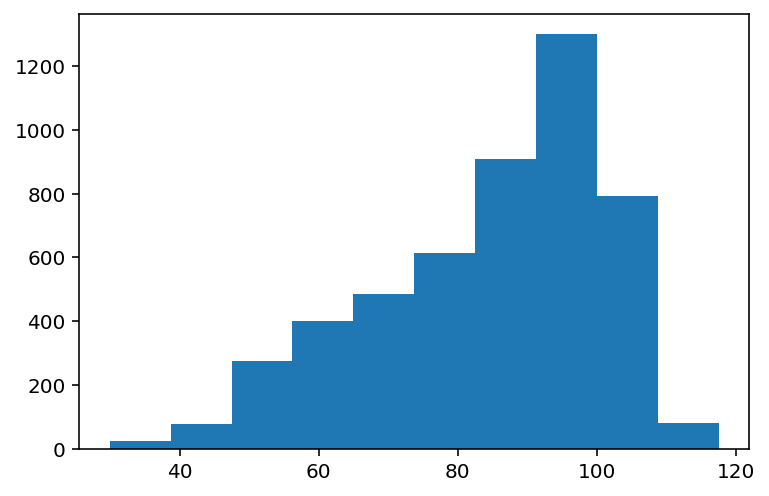

In [830]:
plt.hist(np.abs(np.sum(post_beams, axis=1)/np.sum(post_improv, axis=1)))

Text(0.5, 1.0, 'Magnitude of Postage of True Beams')

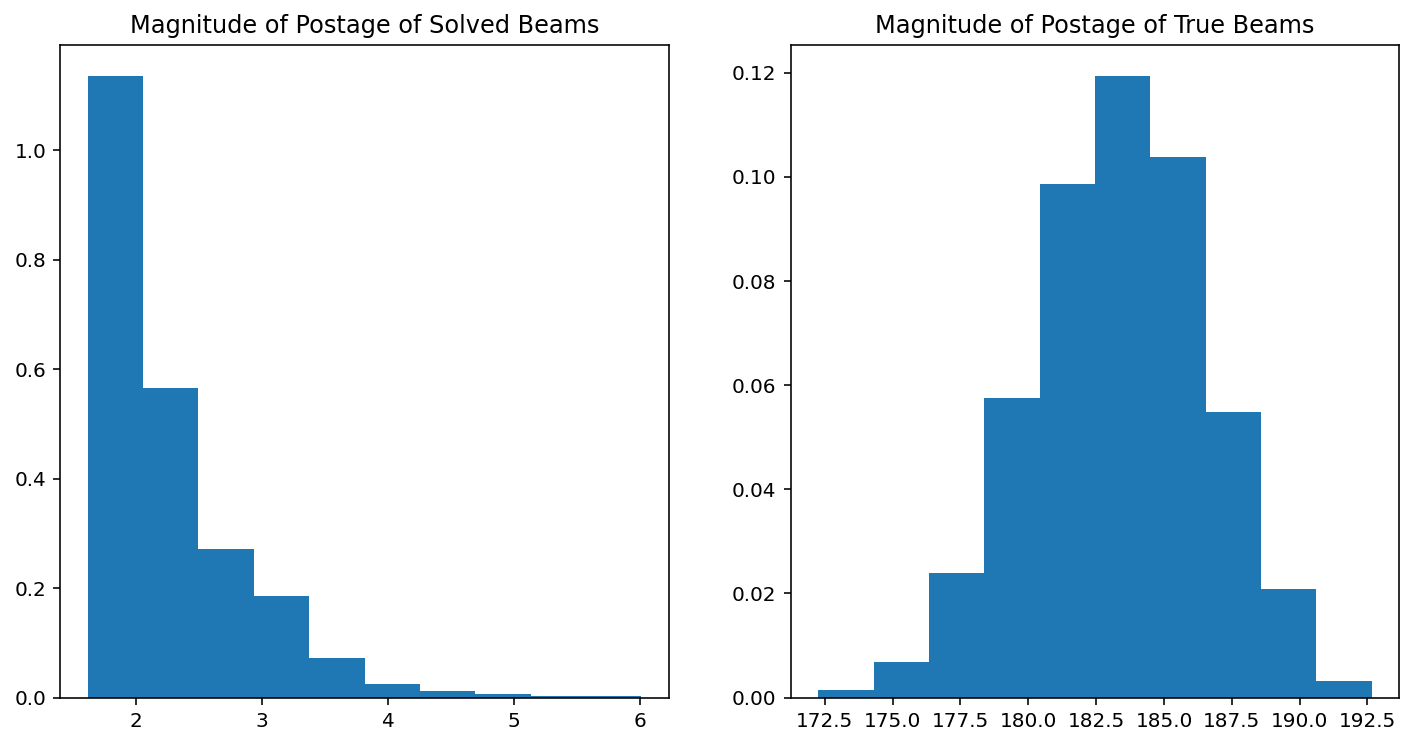

In [831]:
fig, ax = plt.subplots(ncols=2, figsize=(12,6))

ax[0].hist(np.abs(np.sum(post_improv, axis=1)), density=True);
ax[0].set_title("Magnitude of Postage of Solved Beams")
ax[1].hist(np.abs(np.sum(post_beams, axis=1)), density=True);
ax[1].set_title("Magnitude of Postage of True Beams")

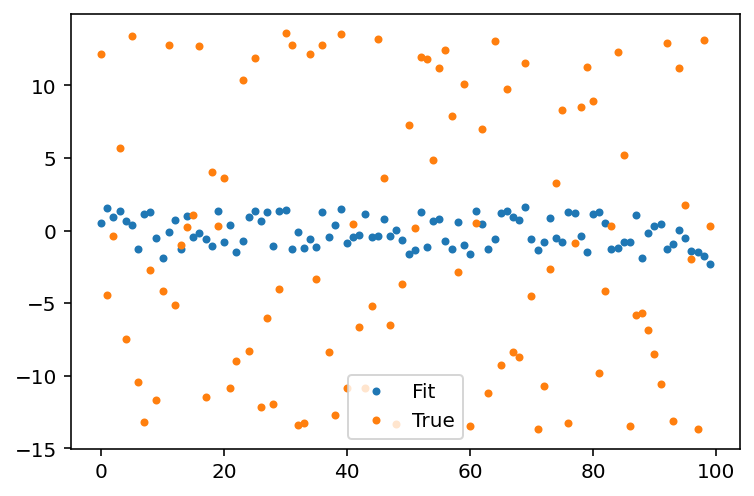

In [832]:
plt.plot(np.arange(Nant), solved_beam_avgs.real, '.', label='Fit');
plt.plot(np.arange(Nant), orig_beam_avgs.real, '.', label='True');
plt.legend();

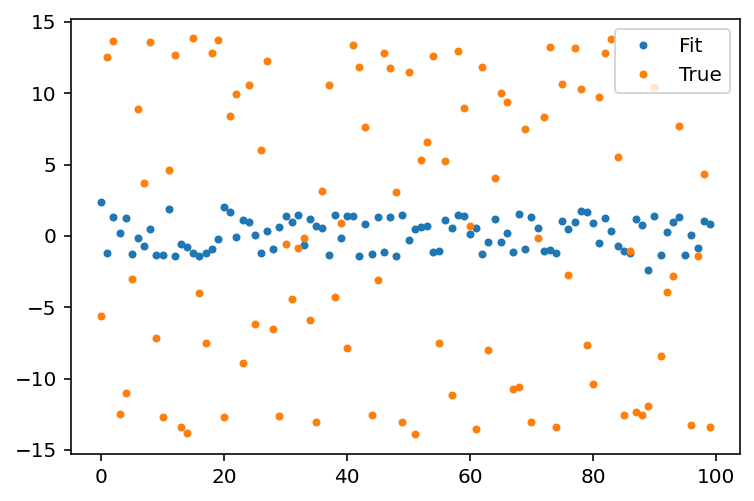

In [833]:
plt.plot(np.arange(Nant), solved_beam_avgs.imag, '.', label='Fit');
plt.plot(np.arange(Nant), orig_beam_avgs.imag, '.', label='True');
plt.legend();

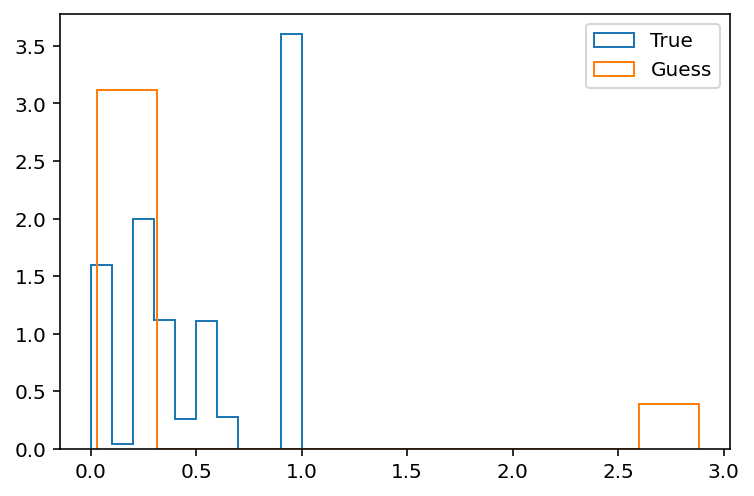

In [834]:
plt.hist(np.abs(beams).flatten(), density=True, stacked=True, histtype='step', fill=False, label='True');
plt.hist(np.abs(improv_beam).flatten(), density=True, stacked=True, histtype='step', fill=False, label='Guess');
plt.legend();

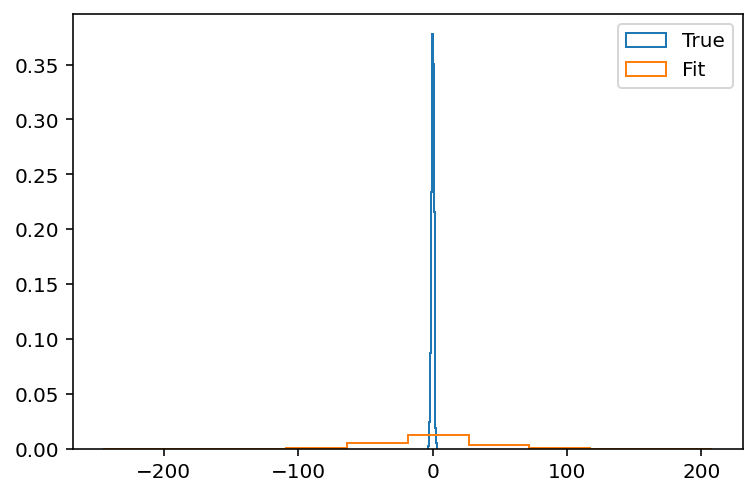

In [720]:
plt.hist(vis_true.imag, density=True, histtype='step', fill=False, label='True');
# plt.hist(bad_guess.real, density=True, histtype='step', fill=False, label='Fit');
plt.hist(itersolve[0].imag, density=True, histtype='step', fill=False, label='Fit');
plt.legend();

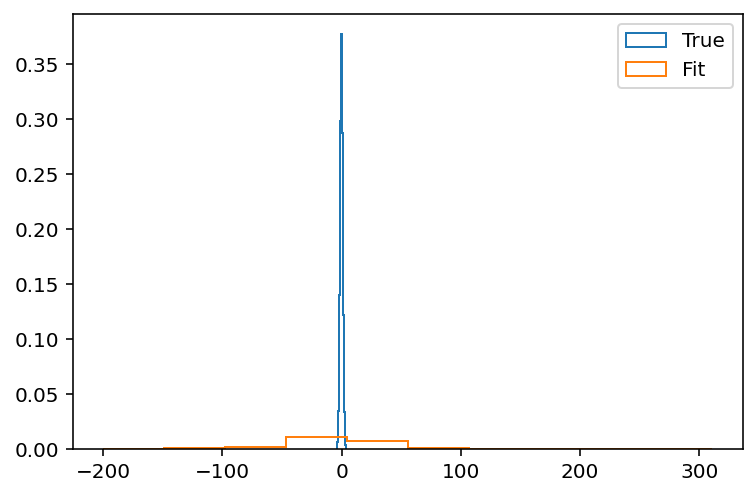

In [721]:
plt.hist(vis_true.real, density=True, histtype='step', fill=False, label='True');
# plt.hist(bad_guess.real, density=True, histtype='step', fill=False, label='Fit');
plt.hist(itersolve[0].real, density=True, histtype='step', fill=False, label='Fit');
plt.legend();

In [1033]:
%%timeit
_ = linear_solver_B(improv_beam, gains_true, data, ant_i, ant_j, fakeflat)

692 ms ± 1.96 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [989]:
bigA, bigB = linear_solver_B(improv_beam, gains_true, data, ant_i, ant_j, fakeflat)

In [1020]:
%%timeit
_ = sparse.linalg.lsqr(bigA, bigB, atol=1e-4)[0]

177 ms ± 13.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [959]:
%%timeit
_ = beam_solver(bad_guess, improv_beam, gains_true, data, ant_i, ant_j, fakeflat, Nside)

954 ms ± 24 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [999]:
%%timeit
_ = vis_solver(bad_guess, improv_beam, gains_true, data, ant_i, ant_j, fakeflat)

1.56 s ± 18.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [1034]:
%%timeit
post = np.array([signal.convolve(improv_beam[ant_i[i]], np.conjugate(improv_beam[ant_j[i]][::-1, ::-1])).flatten()*gains_true[ant_i[i]]*np.conjugate(gains_true[ant_j[i]]) for i in range(len(fakeflat))])

266 ms ± 16 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [1037]:
post.shape

(4950, 441)

In [1044]:
%%timeit
for i in range(len(fakeflat)):
    post[i] = signal.convolve(improv_beam[ant_i[i]], np.conjugate(improv_beam[ant_j[i]][::-1, ::-1])).flatten()*gains_true[ant_i[i]]*np.conjugate(gains_true[ant_j[i]])

246 ms ± 8.04 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [1036]:
%%timeit
lilA.tocsr()

73.7 ms ± 312 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [1508]:
horrific = flat_model(bad_guess, improv_beam, gains_true, ant_i, ant_j, fakeflat)
print("Guess solution ", gen_chi2(data, horrific, noise))

Guess solution  (361034126.6541432, 9900, 36468.093601428605)


In [1561]:
%%timeit
orig_m = vis_solver(bad_guess, improv_beam, gains_true, data, ant_i, ant_j, fakeflat)

8.05 s ± 417 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [1549]:
horrific = flat_model(orig_m, improv_beam, gains_true, ant_i, ant_j, fakeflat)
print("Guess solution ", gen_chi2(data, horrific, noise))

Guess solution  (25807670.751166813, 9900, 2606.8354294107894)


In [1562]:
%%timeit
wein_m = trial_vis_solv(bad_guess, improv_beam, gains_true, data, noise, ant_i, ant_j, fakeflat, fakevislen)

2.48 s ± 18.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [1560]:
horrific = flat_model(wein_m, improv_beam, gains_true, ant_i, ant_j, fakeflat)
print("Guess solution ", gen_chi2(data, horrific, noise))

Guess solution  (26376676.171272844, 9900, 2664.310724370994)
